In [10]:
import sys
import time
import torch
import torchvision

import pandas as pd

from torch import nn, optim, autograd

import matplotlib.pyplot as plt

from dataclasses import dataclass
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

%matplotlib inline

torch.set_num_threads(2)
torch.manual_seed(1)

In [11]:
print(f"python Version: {sys.version.split(' ')[0]}")
print(f"torch Version: {torch.__version__}")
print(f"torchvision Version: {torchvision.__version__}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

python Version: 3.10.7
torch Version: 1.13.0+cu117
torchvision Version: 0.14.0+cu117
GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [12]:
@dataclass
class Hyperparameter:
    batchsize: int          = 128
    num_epochs: int         = 1
    noise_size: int         = 4
    n_critic: int           = 5
    gp_lambda: float        = 10.
        
hp = Hyperparameter()

In [13]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(hp.noise_size + 2, 256), # input: (noise, dist_p, en_p)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 4), # output: (cos_p, de_p, cos_c, en_c)
            nn.Tanh()
        )

    def forward(self, noise, labels):
        out = self.model(torch.cat([noise, labels], dim=1))
        return out.squeeze()

class Critic(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(6, 1024), # input: (cos_p, de_p, cos_c, en_c, dist_p, en_p)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, event, labels):
        out = self.model(torch.cat([event, labels], dim=1))
        return out.squeeze()


In [14]:
class ParticlesDataset(Dataset):

    def __init__(self, path="../pickled_data/water_dataset.pkl", test_size=0.3):
        dataset = pd.read_pickle(path)
        dataset = dataset[dataset["emission"] == 1]

        x = dataset[["cos_p", "de_p", "cos_c", "en_c"]]
        y = dataset[["dist_p", "en_p"]]

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size)

        self.x_train=torch.from_numpy(x_train.values).float()
        self.y_train=torch.from_numpy(y_train.values).float()
        self.x_test = x_test
        self.y_test = y_test

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]


In [15]:
dataset = ParticlesDataset()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=hp.batchsize, num_workers=1, shuffle=True, drop_last=True, pin_memory=True)
critic, generator = Critic().to("cuda"), Generator().to("cuda")

critic_optimizer = optim.AdamW(critic.parameters(), lr=1e-4, betas=(0., 0.9))
generator_optimizer = optim.AdamW(generator.parameters(), lr=1e-4, betas=(0., 0.9))

In [16]:
img_list, generator_losses, critic_losses = [], [], []
iters = 0
grad_tensor = torch.ones((hp.batchsize, 1), device="cuda")

start_time = time.time()
for epoch in range(hp.num_epochs):
    for batch_idx, data in enumerate(dataloader):
        real_images, real_class_labels = data[0].to("cuda"), data[1].to("cuda")
        
        # Update critic
        critic_optimizer.zero_grad()
        
        critic_output_real = critic(real_images, real_class_labels)
        critic_loss_real = critic_output_real.mean()

        noise = torch.randn((hp.batchsize, hp.noise_size), device="cuda")
        with torch.no_grad(): fake_image = generator(noise, real_class_labels)
        critic_output_fake = critic(fake_image, real_class_labels)
        critic_loss_fake = critic_output_fake.mean()

        alpha = torch.rand(1, device="cuda")
        interpolates = (alpha * real_images + (1. - alpha) * fake_image).requires_grad_(True)
        d_interpolates = critic(interpolates, real_class_labels).reshape(-1, 1)
        gradients = autograd.grad(d_interpolates, interpolates, grad_tensor, create_graph=True, only_inputs=True)[0]
        gradient_penalty = hp.gp_lambda * ((gradients.view(hp.batchsize, -1).norm(dim=1) - 1.) ** 2).mean()

        critic_loss = -critic_loss_real + critic_loss_fake  + gradient_penalty
        
        critic_loss.backward()
        critic_optimizer.step()

        if batch_idx % hp.n_critic == 0:
            # Update Generator
            generator_optimizer.zero_grad()
            
            fake_class_labels = dataset.y_train[torch.randint(high=len(dataset), size=[hp.batchsize])].to(device="cuda")
            noise = torch.randn((hp.batchsize, hp.noise_size), device="cuda")
            fake_image = generator(noise, fake_class_labels)
            critic_output_fake = critic(fake_image, fake_class_labels)
            generator_loss = -critic_output_fake.mean()
            
            generator_loss.backward()
            generator_optimizer.step()
        
        # Output training stats
        if batch_idx % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"[{epoch:>2}/{hp.num_epochs}][{iters:>7}][{elapsed_time:8.2f}s]\t"
                  f"d_loss/g_loss: {critic_loss.item():4.2}/{generator_loss.item():4.2}\t")
       
        # Save Losses for plotting later
        generator_losses.append(generator_loss.item())
        critic_losses.append(critic_loss.item())
            
        iters += 1

[ 0/1][      0][    1.07s]	d_loss/g_loss:  9.9/-0.23	
[ 0/1][    100][    1.86s]	d_loss/g_loss:  8.6/-0.54	
[ 0/1][    200][    2.62s]	d_loss/g_loss:  7.8/-0.62	
[ 0/1][    300][    3.34s]	d_loss/g_loss:  7.5/-0.42	
[ 0/1][    400][    4.12s]	d_loss/g_loss:  7.4/-0.59	
[ 0/1][    500][    4.91s]	d_loss/g_loss:  6.8/-0.73	
[ 0/1][    600][    5.69s]	d_loss/g_loss:  6.7/-0.54	
[ 0/1][    700][    6.49s]	d_loss/g_loss:  6.2/-0.62	
[ 0/1][    800][    7.25s]	d_loss/g_loss:  6.6/-0.29	
[ 0/1][    900][    8.15s]	d_loss/g_loss:  5.1/-0.8	
[ 0/1][   1000][    8.93s]	d_loss/g_loss:  5.7/-0.45	
[ 0/1][   1100][    9.73s]	d_loss/g_loss:  6.0/-0.44	
[ 0/1][   1200][   10.56s]	d_loss/g_loss:  5.5/-0.62	
[ 0/1][   1300][   11.34s]	d_loss/g_loss:  6.2/-0.61	
[ 0/1][   1400][   12.06s]	d_loss/g_loss:  5.1/-0.39	
[ 0/1][   1500][   12.76s]	d_loss/g_loss:  6.0/-0.69	
[ 0/1][   1600][   13.42s]	d_loss/g_loss:  6.4/-0.61	
[ 0/1][   1700][   13.94s]	d_loss/g_loss:  5.2/-0.34	
[ 0/1][   1800][   14.52s]	d_

In [17]:
torch.save(generator.state_dict(), "../model_parameters/water/event_prediction.sav")

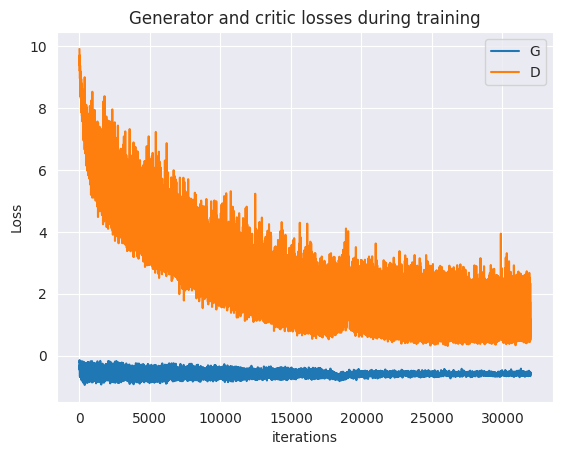

In [18]:
plt.title("Generator and critic losses during training")
plt.plot(generator_losses,label="G")
plt.plot(critic_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()